In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from PIL import Image
from skimage.segmentation import mark_boundaries

root_dir = "../"
os.sys.path.append(root_dir)

from model import Net

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dir = os.path.join(root_dir, "data")
model_dir = os.path.join(root_dir, "pretrained_model")
explanation_dir = os.path.join(root_dir, "explanations")

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = Net()
model.load_state_dict(
    torch.load(os.path.join(model_dir, "model.pt"), map_location=device)
)
model.to(device)
model.eval()
x = torch.randn(1, 3, 100, 120, device=device)
model(x)

mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)

In [2]:
limexp = lime_image.LimeImageExplainer()


def f(x):
    x = torch.stack(tuple(transform(i) for i in x), dim=0)
    x = x.to(device)
    output = model(x)
    p = F.softmax(output, dim=1)
    return p.detach().cpu().numpy()

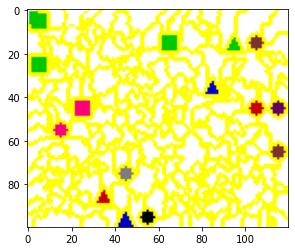

  0%|          | 0/200 [00:00<?, ?it/s]

In [3]:
n = 1
true_positives = np.load(
    os.path.join(explanation_dir, "true_positive.npy"), allow_pickle=True
).item()

for i, image_path in enumerate(true_positives[n]):
    image_name = os.path.basename(image_path).split(".")[0]
    image = Image.open(os.path.join(root_dir, image_path))
    image_RGB = image.convert("RGB")

    image = np.array(image_RGB)
    segmentation_fn = SegmentationAlgorithm(
        "quickshift", kernel_size=1, max_dist=200, ratio=0.2
    )
    segments = segmentation_fn(image)
    plt.imshow(mark_boundaries(image, segments))
    plt.show()

    explanation = limexp.explain_instance(
        image,
        f,
        top_labels=1,
        hide_color=1,
        num_samples=200,
        segmentation_fn=segmentation_fn,
    )
    _, explanation = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=len(explanation.segments),
        hide_rest=False,
    )
    _max = np.amax(np.abs(explanation.flatten()))
    plt.imshow(image)
    plt.imshow(explanation, cmap="bwr", alpha=0.5, vmin=-_max, vmax=_max)
    plt.show()
    break